#Mounting to Google Drive

In [1]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parents[1]))
from Helper_Functions import common_utils, classification_utils
directory_to_extract_to = os.getcwd()

common_utils.load_data_from_one_drive(directory_to_extract_to, "classification_paths", "multi_label_classification")

Extracting : 100%|██████████| 3/3 [00:02<00:00,  1.45it/s]


#Importing Packages

In [5]:
# Ignore harmless warnings
import sys
import warnings
warnings.filterwarnings("ignore")

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import statsmodels as sm
import matplotlib
import math

In [8]:
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain, BinaryRelevance
from sklearn.metrics import accuracy_score,hamming_loss,precision_score,recall_score,f1_score,classification_report
stopwords=stopwords.words('english')
#Removing stopwords 'no','nor' and 'not' as this will affect the overall sentiment
stopwords.remove('no')
stopwords.remove('nor')
stopwords.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rayst\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [ ]:
pip install gensim

In [11]:
import contractions
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec

#Importing CSV File

In [12]:
train=pd.read_csv('train.csv')
print("Columns present in the data: ",[i for i in train.columns])
print("Number of data points: ",train.shape[0])
train.head()

Columns present in the data:  ['ID', 'TITLE', 'ABSTRACT', 'Computer Science', 'Physics', 'Mathematics', 'Statistics', 'Quantitative Biology', 'Quantitative Finance']
Number of data points:  20972


,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0


In [13]:
test=pd.read_csv('test.csv')
test.head()

,ID,TITLE,ABSTRACT
0,20973,Closed-form Marginal Likelihood in Gamma-Poiss...,We present novel understandings of the Gamma...
1,20974,Laboratory mid-IR spectra of equilibrated and ...,Meteorites contain minerals from Solar Syste...
2,20975,Case For Static AMSDU Aggregation in WLANs,Frame aggregation is a mechanism by which mu...
3,20976,The $Gaia$-ESO Survey: the inner disk intermed...,Milky Way open clusters are very diverse in ...
4,20977,Witness-Functions versus Interpretation-Functi...,Proving that a cryptographic protocol is cor...


In [10]:
# sample=pd.read_csv('/content/sample_submission.csv')
# sample.head()

#Preprocessing

##Drop Duplicates

In [15]:
train.drop_duplicates(subset = 'TITLE', inplace = True)
print("Number of new data points: ",train.shape[0])

Number of new data points:  20972


*There are no duplicates*

##Visualization

In [16]:
print(train.iloc[:,3:].sum())

Computer Science        8594
Physics                 6013
Mathematics             5618
Statistics              5206
Quantitative Biology     587
Quantitative Finance     249
dtype: int64


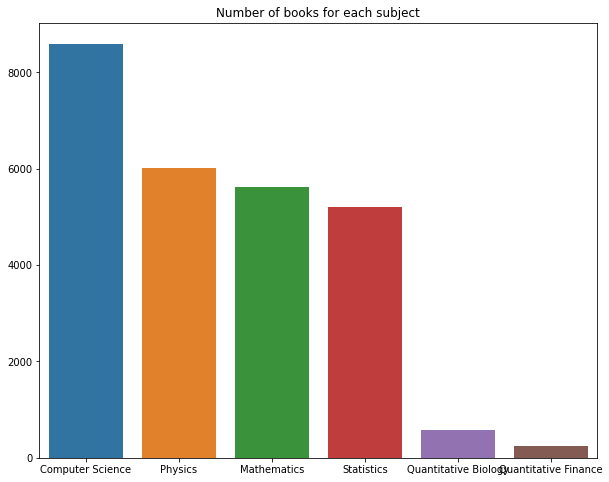

In [17]:
plt.figure(figsize=(10, 8))
plt.title ("Number of books for each subject")
sns.barplot(train.iloc[:,3:].columns, train.iloc[:,3:].sum())
plt.show()

In [18]:
totaltags = []
for i in range(train.shape[0]):
  count = 0
  for j in range(3,9):
    # print(j)
    if train.iloc[i,j] == 1:
      count = count + 1
  totaltags.append(count)

In [19]:
train['tag_count'] = totaltags
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,tag_count
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2


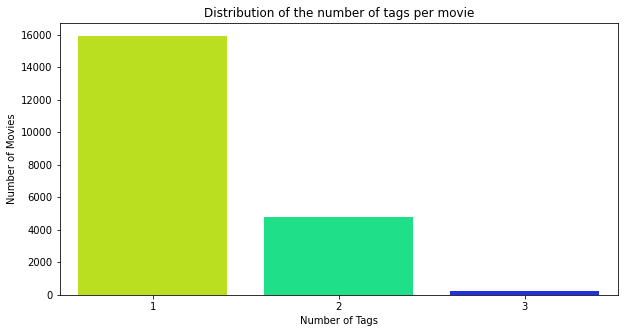

In [20]:
plt.figure(figsize=(10,5))
sns.countplot(train.tag_count, palette='gist_rainbow')
plt.title("Distribution of the number of tags per movie")
plt.xlabel("Number of Tags")
plt.ylabel("Number of Movies")
plt.show()

In [21]:
train.tag_count.value_counts()

1    15928
2     4793
3      251
Name: tag_count, dtype: int64

In [22]:
print('Maximum number of tags per book ', max(totaltags))
print('Minimum number of tags per book ', min(totaltags))
print('Avg number of tags per book ', (sum(totaltags) * 1.0/ len(totaltags)))

Maximum number of tags per book  3
Minimum number of tags per book  1
Avg number of tags per book  1.2524794964714858


In [23]:
#Utiliy functions for feature extraction
#Returns the count of 'http' elements present in a string. Return 0 otherwise.
def count_http(string):
    if string.__contains__("http"):
        return string.count("http")
    else:
        return int(0)
#Returns the number of times a reference link is present in a string
def count_href(string):
    if string.__contains__("a href"):
        return string.count("a href")
    else:
        return int(0)
    
#Number of times a greater than sign appears in a string    
def count_greater(string):
    if string.__contains__(">"):
        return string.count(">")
    else:
        return int(0)
#Simple feature engineering
basic_feats = pd.DataFrame()
basic_feats["Length_Title"] = train['TITLE'].apply(lambda x: len(str(x))) #Length of RAW Title text
basic_feats["Length_Abstract"] = train['ABSTRACT'].apply(lambda x: len(str(x))) #Length of RAW body text
basic_feats['count_Abstract_http'] = train['ABSTRACT'].apply(lambda x: count_http(str(x))) #Lazy way to count the number of URLs present in a body text. Not 100% accurate, but close enough
basic_feats['count_Abstract_href'] = train['ABSTRACT'].apply(lambda x: count_href(str(x))) #Lazy way to count the reference to an externel site. Not 100% accurate, but close enough
basic_feats['count_Abstract_grtsign'] = train['ABSTRACT'].apply(lambda x: count_greater(str(x))) #Very lazy way to count html tags present in a string. Not 100% accurate, but close enough
#Save the dataset containing basic features
basic_feats.to_csv('basic_feats.csv', columns=basic_feats.columns)
basic_feats.head(3)

,Length_Title,Length_Abstract,count_Abstract_http,count_Abstract_href,count_Abstract_grtsign
0,43,1912,0,0,0
1,34,513,0,0,0
2,70,668,0,0,0


In [24]:
#Get a high level stats of the given dataset
basic_feats.describe()

,Length_Title,Length_Abstract,count_Abstract_http,count_Abstract_href,count_Abstract_grtsign
count,20972.000000,20972.000000,20972.000000,20972.0,20972.000000
mean,72.897721,1009.103376,0.010681,0.0,0.041436
std,26.128903,408.641363,0.113805,0.0,0.278879
min,7.000000,7.000000,0.000000,0.0,0.000000
25%,54.000000,714.000000,0.000000,0.0,0.000000
50%,71.000000,989.000000,0.000000,0.0,0.000000
75%,88.000000,1290.000000,0.000000,0.0,0.000000
max,239.000000,2761.000000,5.000000,0.0,8.000000


In [25]:
#Get the percentage of movies which does not have a http referrence included in their body
zero = basic_feats[basic_feats['count_Abstract_http'] == 0].shape[0]
per = (zero/basic_feats.shape[0]) * 100
print("Percentage of movie plots which does not have any http referrence URL in the body text: {:.2f}%".format(per))
#Get the percentage of questions which are provided with external reference links in their body text
zero = basic_feats[basic_feats['count_Abstract_href'] == 0].shape[0]
per = (1-zero/basic_feats.shape[0]) * 100
print("Percentage of movie plots which does not have any external reference: {:.2f}%".format(per))

Percentage of movie plots which does not have any http referrence URL in the body text: 99.02%
Percentage of movie plots which does not have any external reference: 0.00%


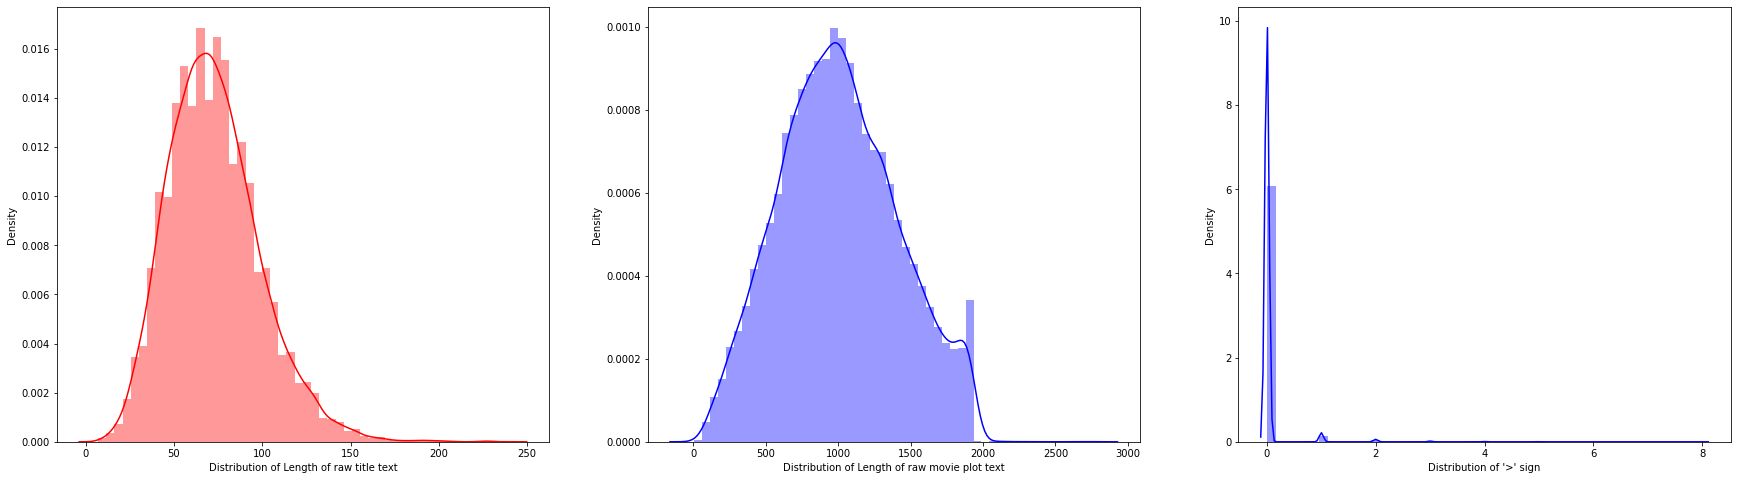

In [26]:
#Draw only PDF 
plt.figure(figsize=(30, 8))
plt.subplot(1,3,1)
sns.distplot([basic_feats['Length_Title']], color = 'red', axlabel="Distribution of Length of raw title text")
plt.subplot(1,3,2)
sns.distplot([basic_feats['Length_Abstract']], color = 'blue', axlabel="Distribution of Length of raw movie plot text")
plt.subplot(1,3,3)
sns.distplot([basic_feats['count_Abstract_grtsign']], color = 'blue', axlabel="Distribution of '>' sign")
plt.show()

##Data Cleaning

In [30]:
processed_mails=[]
for i in tqdm(train['ABSTRACT']):
    #Regular expression that removes all the html tags pressent in the reviews
    i=re.sub('(<[\w\s]*/?>)',"",i)
    #Expanding all the contractions present in the review to is respective actual form
    i=contractions.fix(i)
    #Removing all the special charactesrs from the review text
    i=re.sub('[^a-zA-Z0-9\s]+',"",i)
    #Removing all the digits present in the review text
    i=re.sub('\d+',"",i)
    # i=re.sub('[\n\t\s\b]','',i)
    #Removing the html links
    s=re.sub(r"http\S+", " ", i)
    i=re.sub(r"www.\S+", " ", s)
    #Removing some patterns
    i=re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',i)
    i=re.sub(r"\S*\.com\S*|\S*watch\?\S*",'', i)
    #Making all the review text to be of lower case as well as removing the stopwords and words of length less than 3
    processed_mails.append(" ".join([j.lower() for j in i.split() if j not in stopwords and len(j)>=1]))

100%|██████████| 20972/20972 [00:27<00:00, 751.68it/s]


In [31]:
train['CleanedAbstract'] = processed_mails
train['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in train['CleanedAbstract']]

In [32]:
train.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,tag_count,CleanedAbstract,tokenized_text
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0,1,predictive models allow subjectspecific infere...,"[predictive, models, allow, subjectspecific, i..."
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0,1,rotation invariance translation invariance gre...,"[rotation, invariance, translation, invariance..."
2,3,Spherical polyharmonics and Poisson kernels fo...,We introduce and develop the notion of spher...,0,0,1,0,0,0,1,we introduce develop notion spherical polyharm...,"[we, introduce, develop, notion, spherical, po..."
3,4,A finite element approximation for the stochas...,The stochastic Landau--Lifshitz--Gilbert (LL...,0,0,1,0,0,0,1,the stochastic landaulifshitzgilbert llg equat...,"[the, stochastic, llg, equation, coupled, maxw..."
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier-transform infra-red (FTIR) spectra o...,1,0,0,1,0,0,2,fouriertransform infrared ftir spectra samples...,"[infrared, ftir, spectra, samples, plant, spec..."


#Splitting Data

In [33]:
X=train.iloc[:, 10].copy()
Y=train.iloc[:,3:9].copy()

In [40]:
# splitting data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [41]:
y_train_multilabel = y_train.copy()
y_test_multilabel = y_test.copy()

#TF-IDF Vectorization

##Modeling Word NGrams

###ngram_range = (1,1)

In [ ]:
eval_metrics = {}

In [48]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 27810) Y : (16777, 6)
Dimensions of test data X: (4195, 27810) Y: (4195, 6)


In [50]:
print(X_train_multilabel)

  (0, 1651)	0.06993239321116025
  (0, 9129)	0.08763827819588756
  (0, 4838)	0.062491749419072165
  (0, 8453)	0.07732905711087941
  (0, 25235)	0.06618752838217212
  (0, 17376)	0.08710475384028546
  (0, 19566)	0.18671028635440154
  (0, 905)	0.3227440197377952
  (0, 21147)	0.21269279181169265
  (0, 18179)	0.08317887322997827
  (0, 21900)	0.0709324143063463
  (0, 13745)	0.05939537525162544
  (0, 10065)	0.09732878546678922
  (0, 9139)	0.12198361831651627
  (0, 2901)	0.08736925521341014
  (0, 21960)	0.12972258892650598
  (0, 17029)	0.056443642676350256
  (0, 22269)	0.05011673907663414
  (0, 10366)	0.14350024425080699
  (0, 26626)	0.06869080284917016
  (0, 16920)	0.0457422168539598
  (0, 9413)	0.049535773836234025
  (0, 25258)	0.15153934270718494
  (0, 8150)	0.06984455599014566
  (0, 24865)	0.055559351081963596
  :	:
  (16776, 4424)	0.07454103825652926
  (16776, 17216)	0.07724973007461194
  (16776, 8733)	0.046503487968355864
  (16776, 27435)	0.04141288163750627
  (16776, 24575)	0.043041013238

####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[0] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF 1-1 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6247914183551847
Hamming loss  0.08299562971791816

Micro-average quality numbers
Precision: 0.7706, Recall: 0.8631, F1-measure: 0.8142

Macro-average quality numbers
Precision: 0.7022, Recall: 0.8320, F1-measure: 0.7575

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1692
           1       0.86      0.88      0.87      1226
           2       0.76      0.85      0.80      1150
           3       0.72      0.86      0.78      1069
           4       0.43      0.73      0.54       122
           5       0.65      0.80      0.72        45

   micro avg       0.77      0.86      0.81      5304
   macro avg       0.70      0.83      0.76      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.82      0.89      0.83      5304



####SGDClassifier - Hinge Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[1] = {'Model' : 'SGDClassifier HingeLoss', 'Vectorizer' : 'TF-IDF 1-1 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6305125148986889
Hamming loss  0.08176400476758046

Micro-average quality numbers
Precision: 0.7715, Recall: 0.8695, F1-measure: 0.8176

Macro-average quality numbers
Precision: 0.7175, Recall: 0.8258, F1-measure: 0.7658

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1692
           1       0.86      0.88      0.87      1226
           2       0.75      0.86      0.81      1150
           3       0.71      0.87      0.78      1069
           4       0.47      0.68      0.56       122
           5       0.71      0.78      0.74        45

   micro avg       0.77      0.87      0.82      5304
   macro avg       0.72      0.83      0.77      5304
weighted avg       0.78      0.87      0.82      5304
 samples avg       0.82      0.89      0.83      5304



####SGDClassifier - Log Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[2] = {'Model' : 'SGDClassifier LogLoss', 'Vectorizer' : 'TF-IDF 1-1 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6200238379022646
Hamming loss  0.08363130711164084

Micro-average quality numbers
Precision: 0.7675, Recall: 0.8652, F1-measure: 0.8134

Macro-average quality numbers
Precision: 0.6925, Recall: 0.8335, F1-measure: 0.7514

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.88      0.84      1692
           1       0.86      0.87      0.86      1226
           2       0.76      0.85      0.80      1150
           3       0.72      0.87      0.78      1069
           4       0.41      0.73      0.52       122
           5       0.62      0.80      0.70        45

   micro avg       0.77      0.87      0.81      5304
   macro avg       0.69      0.83      0.75      5304
weighted avg       0.78      0.87      0.82      5304
 samples avg       0.81      0.89      0.83      5304



####Hyperparameter Tuning

In [ ]:
# %%time 

# from sklearn.model_selection import RandomizedSearchCV
# from scipy import stats
# # st=datetime.now()
# alpha = [0.000001,0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
# penalty=['l1','l2']
# params  = {"estimator__C":alpha,
#            "estimator__penalty":penalty}
# base_estimator = OneVsRestClassifier(LogisticRegression(class_weight='balanced'), n_jobs=-1)
# rsearch_cv = RandomizedSearchCV(estimator=base_estimator, param_distributions=params, n_iter=10, cv=5, scoring='f1_micro', n_jobs=-1, verbose=0)
# rsearch_cv.fit(X_train_multilabel, y_train_multilabel)
# # print("Time taken to perform hyperparameter tuning: ",datetime.now()-st)
# print("Best estimator: ",rsearch_cv.best_estimator_)
# print("Best Cross Validation Score: ",rsearch_cv.best_score_)

In [ ]:
# classifier1 = OneVsRestClassifier(LogisticRegression(C = 100, penalty='l2', class_weight='balanced'), n_jobs=-1)
# classifier1.fit(X_train_multilabel, y_train_multilabel)
# predictions = classifier1.predict(X_test_multilabel)
# print("Accuracy :",accuracy_score(y_test_multilabel, predictions))
# print("Hamming loss ",hamming_loss(y_test_multilabel,predictions))
# precision = precision_score(y_test_multilabel, predictions, average='micro')
# recall = recall_score(y_test_multilabel, predictions, average='micro')
# f1 = f1_score(y_test_multilabel, predictions, average='micro')
 
# print("\nMicro-average quality numbers")
# print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
# precision = precision_score(y_test_multilabel, predictions, average='macro')
# recall = recall_score(y_test_multilabel, predictions, average='macro')
# f1 = f1_score(y_test_multilabel, predictions, average='macro')
 
# print("\nMacro-average quality numbers")
# print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
# print("\nClassification Report")
# print (classification_report(y_test_multilabel, predictions))

###ngram_range = (1,2)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 196911) Y : (16777, 6)
Dimensions of test data X: (4195, 196911) Y: (4195, 6)


####Logistic Regression

In [ ]:
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[3] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF 1-2 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6317044100119189
Hamming loss  0.08081048867699643

Micro-average quality numbers
Precision: 0.7777, Recall: 0.8633, F1-measure: 0.8183

Macro-average quality numbers
Precision: 0.7298, Recall: 0.8122, F1-measure: 0.7663

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1692
           1       0.87      0.87      0.87      1226
           2       0.77      0.84      0.81      1150
           3       0.71      0.87      0.78      1069
           4       0.48      0.67      0.56       122
           5       0.75      0.73      0.74        45

   micro avg       0.78      0.86      0.82      5304
   macro avg       0.73      0.81      0.77      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.82      0.89      0.83      5304



####SGDClassifier - Hinge Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[4] = {'Model' : 'SGDClassifier HingeLoss', 'Vectorizer' : 'TF-IDF 1-2 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6519666269368296
Hamming loss  0.07628128724672228

Micro-average quality numbers
Precision: 0.7895, Recall: 0.8699, F1-measure: 0.8278

Macro-average quality numbers
Precision: 0.7553, Recall: 0.8015, F1-measure: 0.7760

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1692
           1       0.89      0.88      0.88      1226
           2       0.78      0.85      0.82      1150
           3       0.72      0.87      0.79      1069
           4       0.57      0.60      0.58       122
           5       0.78      0.71      0.74        45

   micro avg       0.79      0.87      0.83      5304
   macro avg       0.76      0.80      0.78      5304
weighted avg       0.79      0.87      0.83      5304
 samples avg       0.83      0.89      0.84      5304



####SGDClassifier - Log loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[5] = {'Model' : 'SGDClassifier LogLoss', 'Vectorizer' : 'TF-IDF 1-2 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6214541120381406
Hamming loss  0.08315454906634882

Micro-average quality numbers
Precision: 0.7693, Recall: 0.8646, F1-measure: 0.8142

Macro-average quality numbers
Precision: 0.7146, Recall: 0.8208, F1-measure: 0.7605

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1692
           1       0.87      0.87      0.87      1226
           2       0.77      0.85      0.80      1150
           3       0.70      0.87      0.77      1069
           4       0.44      0.70      0.54       122
           5       0.72      0.76      0.74        45

   micro avg       0.77      0.86      0.81      5304
   macro avg       0.71      0.82      0.76      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.81      0.89      0.83      5304



###ngram_range = (1,3)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 252121) Y : (16777, 6)
Dimensions of test data X: (4195, 252121) Y: (4195, 6)


####Logistic Regression

In [ ]:
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[6] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF 1-3 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6324195470798569
Hamming loss  0.08049264998013508

Micro-average quality numbers
Precision: 0.7776, Recall: 0.8656, F1-measure: 0.8192

Macro-average quality numbers
Precision: 0.7303, Recall: 0.8065, F1-measure: 0.7633

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1692
           1       0.87      0.87      0.87      1226
           2       0.78      0.84      0.81      1150
           3       0.71      0.87      0.78      1069
           4       0.48      0.67      0.56       122
           5       0.76      0.69      0.72        45

   micro avg       0.78      0.87      0.82      5304
   macro avg       0.73      0.81      0.76      5304
weighted avg       0.78      0.87      0.82      5304
 samples avg       0.82      0.89      0.83      5304



####SGDClassifier - Hinge Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[7] = {'Model' : 'SGDClassifier HingeLoss', 'Vectorizer' : 'TF-IDF 1-3 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6512514898688916
Hamming loss  0.07624155740961462

Micro-average quality numbers
Precision: 0.7893, Recall: 0.8707, F1-measure: 0.8280

Macro-average quality numbers
Precision: 0.7600, Recall: 0.7974, F1-measure: 0.7757

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      1692
           1       0.88      0.88      0.88      1226
           2       0.79      0.84      0.82      1150
           3       0.72      0.88      0.79      1069
           4       0.56      0.59      0.58       122
           5       0.82      0.69      0.75        45

   micro avg       0.79      0.87      0.83      5304
   macro avg       0.76      0.80      0.78      5304
weighted avg       0.79      0.87      0.83      5304
 samples avg       0.83      0.89      0.84      5304



####SGDClassifier - Log Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[8] = {'Model' : 'SGDClassifier LogLoss', 'Vectorizer' : 'TF-IDF 1-3 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6188319427890345
Hamming loss  0.08351211760031783

Micro-average quality numbers
Precision: 0.7672, Recall: 0.8667, F1-measure: 0.8139

Macro-average quality numbers
Precision: 0.7154, Recall: 0.8206, F1-measure: 0.7613

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1692
           1       0.87      0.87      0.87      1226
           2       0.77      0.85      0.81      1150
           3       0.69      0.88      0.77      1069
           4       0.45      0.69      0.55       122
           5       0.72      0.76      0.74        45

   micro avg       0.77      0.87      0.81      5304
   macro avg       0.72      0.82      0.76      5304
weighted avg       0.77      0.87      0.82      5304
 samples avg       0.81      0.89      0.83      5304



###ngram_range = (1,4)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(1,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 267522) Y : (16777, 6)
Dimensions of test data X: (4195, 267522) Y: (4195, 6)


####Logistic Regression

In [ ]:
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[9] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF 1-4 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6302741358760429
Hamming loss  0.0808502185141041

Micro-average quality numbers
Precision: 0.7766, Recall: 0.8652, F1-measure: 0.8185

Macro-average quality numbers
Precision: 0.7297, Recall: 0.8064, F1-measure: 0.7629

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1692
           1       0.87      0.87      0.87      1226
           2       0.78      0.84      0.81      1150
           3       0.71      0.88      0.78      1069
           4       0.48      0.67      0.56       122
           5       0.76      0.69      0.72        45

   micro avg       0.78      0.87      0.82      5304
   macro avg       0.73      0.81      0.76      5304
weighted avg       0.78      0.87      0.82      5304
 samples avg       0.82      0.89      0.83      5304



####SGDClassifier - Hinge Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[10] = {'Model' : 'SGDClassifier HingeLoss', 'Vectorizer' : 'TF-IDF 1-4 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6531585220500596
Hamming loss  0.07572506952721494

Micro-average quality numbers
Precision: 0.7906, Recall: 0.8714, F1-measure: 0.8291

Macro-average quality numbers
Precision: 0.7549, Recall: 0.7975, F1-measure: 0.7740

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.90      0.85      1692
           1       0.88      0.88      0.88      1226
           2       0.79      0.85      0.82      1150
           3       0.72      0.87      0.79      1069
           4       0.56      0.57      0.56       122
           5       0.78      0.71      0.74        45

   micro avg       0.79      0.87      0.83      5304
   macro avg       0.75      0.80      0.77      5304
weighted avg       0.79      0.87      0.83      5304
 samples avg       0.83      0.89      0.84      5304



####SGDClassifier - Log Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[11] = {'Model' : 'SGDClassifier LogLoss', 'Vectorizer' : 'TF-IDF 1-4 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6181168057210965
Hamming loss  0.08375049662296384

Micro-average quality numbers
Precision: 0.7660, Recall: 0.8676, F1-measure: 0.8136

Macro-average quality numbers
Precision: 0.7129, Recall: 0.8249, F1-measure: 0.7608

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1692
           1       0.87      0.87      0.87      1226
           2       0.77      0.85      0.81      1150
           3       0.69      0.87      0.77      1069
           4       0.44      0.71      0.54       122
           5       0.72      0.76      0.74        45

   micro avg       0.77      0.87      0.81      5304
   macro avg       0.71      0.82      0.76      5304
weighted avg       0.77      0.87      0.82      5304
 samples avg       0.81      0.89      0.83      5304



###ngram_range = (2,2/Bigrams)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 182635) Y : (16777, 6)
Dimensions of test data X: (4195, 182635) Y: (4195, 6)


####Logistic Regression

In [ ]:
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[12] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF BiGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6205005959475566
Hamming loss  0.08446563369090186

Micro-average quality numbers
Precision: 0.7972, Recall: 0.8035, F1-measure: 0.8004

Macro-average quality numbers
Precision: 0.7854, Recall: 0.6072, F1-measure: 0.6371

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.82      1692
           1       0.90      0.84      0.87      1226
           2       0.81      0.78      0.79      1150
           3       0.72      0.80      0.76      1069
           4       0.61      0.16      0.26       122
           5       0.90      0.20      0.33        45

   micro avg       0.80      0.80      0.80      5304
   macro avg       0.79      0.61      0.64      5304
weighted avg       0.80      0.80      0.80      5304
 samples avg       0.79      0.83      0.79      5304



####SGDClassifier - Hinge Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[13] = {'Model' : 'SGDClassifier HingeLoss', 'Vectorizer' : 'TF-IDF BiGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6381406436233611
Hamming loss  0.0809694080254271

Micro-average quality numbers
Precision: 0.8034, Recall: 0.8152, F1-measure: 0.8093

Macro-average quality numbers
Precision: 0.7743, Recall: 0.6216, F1-measure: 0.6508

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1692
           1       0.91      0.84      0.88      1226
           2       0.81      0.80      0.80      1150
           3       0.73      0.81      0.76      1069
           4       0.62      0.16      0.26       122
           5       0.79      0.24      0.37        45

   micro avg       0.80      0.82      0.81      5304
   macro avg       0.77      0.62      0.65      5304
weighted avg       0.80      0.82      0.80      5304
 samples avg       0.81      0.84      0.80      5304



####SGDClassifier - Log Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[14] = {'Model' : 'SGDClassifier LogLoss', 'Vectorizer' : 'TF-IDF BiGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.6109654350417163
Hamming loss  0.08696861342868495

Micro-average quality numbers
Precision: 0.7879, Recall: 0.8035, F1-measure: 0.7957

Macro-average quality numbers
Precision: 0.7745, Recall: 0.6258, F1-measure: 0.6566

Classification Report
              precision    recall  f1-score   support

           0       0.78      0.85      0.81      1692
           1       0.90      0.84      0.87      1226
           2       0.79      0.77      0.78      1150
           3       0.71      0.81      0.75      1069
           4       0.63      0.24      0.35       122
           5       0.85      0.24      0.38        45

   micro avg       0.79      0.80      0.80      5304
   macro avg       0.77      0.63      0.66      5304
weighted avg       0.79      0.80      0.79      5304
 samples avg       0.79      0.83      0.79      5304



###ngram_range = (3,3/Tirgrams)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 55210) Y : (16777, 6)
Dimensions of test data X: (4195, 55210) Y: (4195, 6)


####Logistic Regression

In [ ]:
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[15] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF TriGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.4641239570917759
Hamming loss  0.12344060389352404

Micro-average quality numbers
Precision: 0.7295, Recall: 0.6584, F1-measure: 0.6921

Macro-average quality numbers
Precision: 0.6204, Recall: 0.5098, F1-measure: 0.5515

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.72      0.73      1692
           1       0.81      0.66      0.73      1226
           2       0.74      0.62      0.67      1150
           3       0.66      0.67      0.66      1069
           4       0.39      0.16      0.23       122
           5       0.38      0.22      0.28        45

   micro avg       0.73      0.66      0.69      5304
   macro avg       0.62      0.51      0.55      5304
weighted avg       0.73      0.66      0.69      5304
 samples avg       0.64      0.67      0.63      5304



####SGDClassifier - Hinge Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[16] = {'Model' : 'SGDClassifier HingeLoss', 'Vectorizer' : 'TF-IDF TriGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.4717520858164482
Hamming loss  0.12316249503377036

Micro-average quality numbers
Precision: 0.7307, Recall: 0.6580, F1-measure: 0.6925

Macro-average quality numbers
Precision: 0.6027, Recall: 0.5066, F1-measure: 0.5444

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1692
           1       0.82      0.66      0.73      1226
           2       0.75      0.60      0.67      1150
           3       0.66      0.68      0.67      1069
           4       0.33      0.15      0.20       122
           5       0.32      0.22      0.26        45

   micro avg       0.73      0.66      0.69      5304
   macro avg       0.60      0.51      0.54      5304
weighted avg       0.73      0.66      0.69      5304
 samples avg       0.64      0.67      0.64      5304



####SGDClassifier - Log Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[17] = {'Model' : 'SGDClassifier LogLoss', 'Vectorizer' : 'TF-IDF TriGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.4536352800953516
Hamming loss  0.12574493444576879

Micro-average quality numbers
Precision: 0.7189, Recall: 0.6621, F1-measure: 0.6894

Macro-average quality numbers
Precision: 0.6000, Recall: 0.5146, F1-measure: 0.5489

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.73      0.73      1692
           1       0.80      0.66      0.73      1226
           2       0.72      0.60      0.66      1150
           3       0.65      0.68      0.67      1069
           4       0.31      0.18      0.23       122
           5       0.38      0.22      0.28        45

   micro avg       0.72      0.66      0.69      5304
   macro avg       0.60      0.51      0.55      5304
weighted avg       0.72      0.66      0.69      5304
 samples avg       0.63      0.67      0.63      5304



###ngram_range = (4,4)

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 15401) Y : (16777, 6)
Dimensions of test data X: (4195, 15401) Y: (4195, 6)


####Logistic Regression

In [ ]:
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[18] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF 4 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.19856972586412397
Hamming loss  0.17655939610647597

Micro-average quality numbers
Precision: 0.6534, Recall: 0.3454, F1-measure: 0.4519

Macro-average quality numbers
Precision: 0.4931, Recall: 0.2713, F1-measure: 0.3472

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.35      0.47      1692
           1       0.71      0.33      0.45      1226
           2       0.65      0.37      0.47      1150
           3       0.62      0.37      0.46      1069
           4       0.15      0.10      0.12       122
           5       0.11      0.11      0.11        45

   micro avg       0.65      0.35      0.45      5304
   macro avg       0.49      0.27      0.35      5304
weighted avg       0.67      0.35      0.45      5304
 samples avg       0.31      0.35      0.32      5304



####SGDClassifier - Hinge Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[19] = {'Model' : 'SGDClassifier HingeLoss', 'Vectorizer' : 'TF-IDF 4 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.2128724672228844
Hamming loss  0.17302344060389352

Micro-average quality numbers
Precision: 0.6836, Recall: 0.3331, F1-measure: 0.4480

Macro-average quality numbers
Precision: 0.5219, Recall: 0.2567, F1-measure: 0.3430

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.35      0.48      1692
           1       0.75      0.32      0.45      1226
           2       0.67      0.35      0.46      1150
           3       0.62      0.35      0.44      1069
           4       0.21      0.09      0.13       122
           5       0.13      0.09      0.11        45

   micro avg       0.68      0.33      0.45      5304
   macro avg       0.52      0.26      0.34      5304
weighted avg       0.69      0.33      0.45      5304
 samples avg       0.31      0.34      0.31      5304



####SGDClassifier - Log Loss

In [ ]:
classifier1 = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro')
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[20] = {'Model' : 'SGDClassifier LogLoss', 'Vectorizer' : 'TF-IDF 4 Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro')
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))

Accuracy : 0.19165673420738974
Hamming loss  0.17854588796185936

Micro-average quality numbers
Precision: 0.6404, Recall: 0.3482, F1-measure: 0.4511

Macro-average quality numbers
Precision: 0.4820, Recall: 0.2735, F1-measure: 0.3457

Classification Report
              precision    recall  f1-score   support

           0       0.73      0.35      0.47      1692
           1       0.69      0.33      0.45      1226
           2       0.63      0.38      0.47      1150
           3       0.61      0.37      0.46      1069
           4       0.12      0.10      0.11       122
           5       0.11      0.11      0.11        45

   micro avg       0.64      0.35      0.45      5304
   macro avg       0.48      0.27      0.35      5304
weighted avg       0.66      0.35      0.45      5304
 samples avg       0.30      0.35      0.31      5304



##Modeling Char NGrams

###Char Unigram

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(1,1))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 27) Y : (16777, 6)
Dimensions of test data X: (4195, 27) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[21] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char UniGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.13015494636471991
Hamming loss  0.31529598728645214

Micro-average quality numbers
Precision: 0.3703, Recall: 0.7083, F1-measure: 0.4863

Macro-average quality numbers
Precision: 0.3449, Recall: 0.7085, F1-measure: 0.4129

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      1692
           1       0.45      0.71      0.55      1226
           2       0.53      0.67      0.60      1150
           3       0.43      0.74      0.54      1069
           4       0.06      0.73      0.10       122
           5       0.03      0.69      0.05        45

   micro avg       0.37      0.71      0.49      5304
   macro avg       0.34      0.71      0.41      5304
weighted avg       0.49      0.71      0.57      5304
 samples avg       0.42      0.72      0.50      5304



###Char Bigram

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(2,2))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 703) Y : (16777, 6)
Dimensions of test data X: (4195, 703) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[22] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char BiGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.4371871275327771
Hamming loss  0.14211362733412794

Micro-average quality numbers
Precision: 0.6223, Recall: 0.8284, F1-measure: 0.7107

Macro-average quality numbers
Precision: 0.5048, Recall: 0.8046, F1-measure: 0.5761

Classification Report
              precision    recall  f1-score   support

           0       0.74      0.83      0.78      1692
           1       0.73      0.84      0.78      1226
           2       0.68      0.83      0.75      1150
           3       0.62      0.84      0.72      1069
           4       0.14      0.70      0.23       122
           5       0.12      0.80      0.20        45

   micro avg       0.62      0.83      0.71      5304
   macro avg       0.50      0.80      0.58      5304
weighted avg       0.68      0.83      0.74      5304
 samples avg       0.69      0.85      0.73      5304



###Char Trigram

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(3,3))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 8635) Y : (16777, 6)
Dimensions of test data X: (4195, 8635) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[23] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char TriGrams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.5914183551847437
Hamming loss  0.09276916964640446

Micro-average quality numbers
Precision: 0.7422, Recall: 0.8577, F1-measure: 0.7958

Macro-average quality numbers
Precision: 0.6306, Recall: 0.8131, F1-measure: 0.7002

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1692
           1       0.84      0.88      0.86      1226
           2       0.73      0.86      0.79      1150
           3       0.69      0.86      0.77      1069
           4       0.32      0.67      0.44       122
           5       0.40      0.76      0.53        45

   micro avg       0.74      0.86      0.80      5304
   macro avg       0.63      0.81      0.70      5304
weighted avg       0.76      0.86      0.80      5304
 samples avg       0.79      0.88      0.81      5304



###Char 4-gram

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(4,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 41182) Y : (16777, 6)
Dimensions of test data X: (4195, 41182) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[24] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char 4-Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6197854588796186
Hamming loss  0.08414779499404053

Micro-average quality numbers
Precision: 0.7674, Recall: 0.8620, F1-measure: 0.8119

Macro-average quality numbers
Precision: 0.6866, Recall: 0.8085, F1-measure: 0.7395

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1692
           1       0.86      0.88      0.87      1226
           2       0.75      0.85      0.80      1150
           3       0.72      0.86      0.78      1069
           4       0.42      0.67      0.51       122
           5       0.58      0.71      0.64        45

   micro avg       0.77      0.86      0.81      5304
   macro avg       0.69      0.81      0.74      5304
weighted avg       0.77      0.86      0.81      5304
 samples avg       0.81      0.89      0.82      5304



###Char 5-gram

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(5,5))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 127347) Y : (16777, 6)
Dimensions of test data X: (4195, 127347) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[25] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char 5-Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6295589988081048
Hamming loss  0.0810885975367501

Micro-average quality numbers
Precision: 0.7774, Recall: 0.8620, F1-measure: 0.8175

Macro-average quality numbers
Precision: 0.7250, Recall: 0.8038, F1-measure: 0.7595

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1692
           1       0.87      0.88      0.87      1226
           2       0.76      0.86      0.81      1150
           3       0.72      0.86      0.78      1069
           4       0.46      0.66      0.55       122
           5       0.74      0.69      0.71        45

   micro avg       0.78      0.86      0.82      5304
   macro avg       0.73      0.80      0.76      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.82      0.89      0.83      5304



###Char 6-gram

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(6,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 305426) Y : (16777, 6)
Dimensions of test data X: (4195, 305426) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[26] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char 6-Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.633611442193087
Hamming loss  0.0802145411203814

Micro-average quality numbers
Precision: 0.7831, Recall: 0.8565, F1-measure: 0.8182

Macro-average quality numbers
Precision: 0.7363, Recall: 0.7899, F1-measure: 0.7589

Classification Report
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1692
           1       0.87      0.87      0.87      1226
           2       0.77      0.85      0.81      1150
           3       0.73      0.86      0.79      1069
           4       0.49      0.65      0.56       122
           5       0.76      0.64      0.70        45

   micro avg       0.78      0.86      0.82      5304
   macro avg       0.74      0.79      0.76      5304
weighted avg       0.79      0.86      0.82      5304
 samples avg       0.82      0.88      0.83      5304



###Char (2,4)grams

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(2,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 50520) Y : (16777, 6)
Dimensions of test data X: (4195, 50520) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[27] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char (2,4)Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6085816448152562
Hamming loss  0.08736591179976162

Micro-average quality numbers
Precision: 0.7572, Recall: 0.8616, F1-measure: 0.8061

Macro-average quality numbers
Precision: 0.6592, Recall: 0.8141, F1-measure: 0.7227

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1692
           1       0.86      0.88      0.87      1226
           2       0.74      0.85      0.79      1150
           3       0.71      0.86      0.78      1069
           4       0.37      0.66      0.48       122
           5       0.49      0.76      0.59        45

   micro avg       0.76      0.86      0.81      5304
   macro avg       0.66      0.81      0.72      5304
weighted avg       0.77      0.86      0.81      5304
 samples avg       0.80      0.89      0.82      5304



###Char (2,6)grams

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(2,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 483293) Y : (16777, 6)
Dimensions of test data X: (4195, 483293) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[28] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char (2,6)Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6252681764004767
Hamming loss  0.08208184346444179

Micro-average quality numbers
Precision: 0.7734, Recall: 0.8635, F1-measure: 0.8160

Macro-average quality numbers
Precision: 0.7107, Recall: 0.8094, F1-measure: 0.7542

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1692
           1       0.87      0.88      0.87      1226
           2       0.76      0.86      0.81      1150
           3       0.72      0.86      0.78      1069
           4       0.45      0.67      0.54       122
           5       0.68      0.71      0.70        45

   micro avg       0.77      0.86      0.82      5304
   macro avg       0.71      0.81      0.75      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.81      0.89      0.83      5304



###Char (3,4)grams

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(3,4))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 49817) Y : (16777, 6)
Dimensions of test data X: (4195, 49817) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[29] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char (3,4)Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6159713945172824
Hamming loss  0.08557806912991657

Micro-average quality numbers
Precision: 0.7621, Recall: 0.8635, F1-measure: 0.8096

Macro-average quality numbers
Precision: 0.6690, Recall: 0.8106, F1-measure: 0.7290

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1692
           1       0.86      0.88      0.87      1226
           2       0.75      0.86      0.80      1150
           3       0.71      0.86      0.78      1069
           4       0.40      0.66      0.50       122
           5       0.51      0.73      0.60        45

   micro avg       0.76      0.86      0.81      5304
   macro avg       0.67      0.81      0.73      5304
weighted avg       0.77      0.86      0.81      5304
 samples avg       0.81      0.89      0.82      5304



###Char (3,6)grams

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(3,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 482590) Y : (16777, 6)
Dimensions of test data X: (4195, 482590) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[30] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char (3,6)Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6278903456495828
Hamming loss  0.08188319427890346

Micro-average quality numbers
Precision: 0.7747, Recall: 0.8622, F1-measure: 0.8161

Macro-average quality numbers
Precision: 0.7141, Recall: 0.8061, F1-measure: 0.7549

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1692
           1       0.87      0.88      0.87      1226
           2       0.76      0.86      0.81      1150
           3       0.72      0.86      0.79      1069
           4       0.45      0.66      0.53       122
           5       0.70      0.71      0.70        45

   micro avg       0.77      0.86      0.82      5304
   macro avg       0.71      0.81      0.75      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.81      0.89      0.83      5304



###Char (4,6)grams

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(4,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 473955) Y : (16777, 6)
Dimensions of test data X: (4195, 473955) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[31] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char (4,6)Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6300357568533969
Hamming loss  0.08124751688518077

Micro-average quality numbers
Precision: 0.7775, Recall: 0.8609, F1-measure: 0.8170

Macro-average quality numbers
Precision: 0.7253, Recall: 0.8016, F1-measure: 0.7589

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1692
           1       0.87      0.88      0.87      1226
           2       0.76      0.86      0.81      1150
           3       0.72      0.86      0.78      1069
           4       0.47      0.66      0.54       122
           5       0.74      0.69      0.71        45

   micro avg       0.78      0.86      0.82      5304
   macro avg       0.73      0.80      0.76      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.82      0.89      0.83      5304



###Char (5,6)grams

In [ ]:
vectorizer = TfidfVectorizer(min_df=0.00009, smooth_idf=True, norm="l2", tokenizer = lambda x: x.split(" "), sublinear_tf=False, analyzer = 'char', ngram_range=(5,6))
X_train_multilabel = vectorizer.fit_transform(X_train)
X_test_multilabel = vectorizer.transform(X_test)
print("Dimensions of train data X:",X_train_multilabel.shape, "Y :",y_train_multilabel.shape)
print("Dimensions of test data X:",X_test_multilabel.shape,"Y:",y_test_multilabel.shape)

Dimensions of train data X: (16777, 432773) Y : (16777, 6)
Dimensions of test data X: (4195, 432773) Y: (4195, 6)


####Logistic Regression

In [ ]:
# start = datetime.now()
classifier1 = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight='balanced'), n_jobs=-1)
classifier1.fit(X_train_multilabel, y_train_multilabel)
predictions = classifier1.predict(X_test_multilabel)

accuracy = accuracy_score(y_test_multilabel, predictions)
hammingloss = hamming_loss(y_test_multilabel,predictions)
print("Accuracy :",accuracy)
print("Hamming loss ",hammingloss)

precision = precision_score(y_test_multilabel, predictions, average='micro')
recall = recall_score(y_test_multilabel, predictions, average='micro')
f1 = f1_score(y_test_multilabel, predictions, average='micro') 
print("\nMicro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))
eval_metrics[32] = {'Model' : 'Logistic Regression', 'Vectorizer' : 'TF-IDF Char (5,6))Grams', 'Accuracy' : accuracy, 'Hamming loss' : hammingloss, 'Precision' : precision, 'Recall' : recall, 'F1-Score' : f1}

precision = precision_score(y_test_multilabel, predictions, average='macro')
recall = recall_score(y_test_multilabel, predictions, average='macro')
f1 = f1_score(y_test_multilabel, predictions, average='macro') 
print("\nMacro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print("\nClassification Report")
print (classification_report(y_test_multilabel, predictions))
# print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.6317044100119189
Hamming loss  0.08057210965435042

Micro-average quality numbers
Precision: 0.7801, Recall: 0.8601, F1-measure: 0.8181

Macro-average quality numbers
Precision: 0.7344, Recall: 0.7975, F1-measure: 0.7615

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1692
           1       0.87      0.87      0.87      1226
           2       0.77      0.85      0.81      1150
           3       0.72      0.86      0.79      1069
           4       0.48      0.66      0.56       122
           5       0.77      0.67      0.71        45

   micro avg       0.78      0.86      0.82      5304
   macro avg       0.73      0.80      0.76      5304
weighted avg       0.78      0.86      0.82      5304
 samples avg       0.82      0.89      0.83      5304



##Final Table

In [ ]:
df = pd.DataFrame(eval_metrics)

In [ ]:
df_T = df.T
# print('\tWord NGrams - Comparing the scores of each models')
df_T

,Model,Vectorizer,Accuracy,Hamming loss,Precision,Recall,F1-Score
0,Logistic Regression,TF-IDF 1-1 Grams,0.624791,0.082996,0.770577,0.863122,0.814229
1,SGDClassifier HingeLoss,TF-IDF 1-1 Grams,0.630513,0.081764,0.771495,0.869532,0.817586
2,SGDClassifier LogLoss,TF-IDF 1-1 Grams,0.620024,0.083631,0.76752,0.865196,0.813436
3,Logistic Regression,TF-IDF 1-2 Grams,0.631704,0.08081,0.777683,0.863311,0.818263
4,SGDClassifier HingeLoss,TF-IDF 1-2 Grams,0.651967,0.076281,0.789528,0.86991,0.827772
5,SGDClassifier LogLoss,TF-IDF 1-2 Grams,0.621454,0.083155,0.769334,0.86463,0.814203
6,Logistic Regression,TF-IDF 1-3 Grams,0.63242,0.080493,0.777608,0.865573,0.819236
7,SGDClassifier HingeLoss,TF-IDF 1-3 Grams,0.651251,0.076242,0.789267,0.870664,0.82797
8,SGDClassifier LogLoss,TF-IDF 1-3 Grams,0.618832,0.083512,0.76719,0.866704,0.813916
9,Logistic Regression,TF-IDF 1-4 Grams,0.630274,0.08085,0.776612,0.865196,0.818514


In [ ]:
df_T[['Precision', 'Recall', 'F1-Score']].describe()

,Precision,Recall,F1-Score
count,33.000000,33.000000,33.000000
unique,33.000000,29.000000,33.000000
top,0.770577,0.865196,0.814229
freq,1.000000,2.000000,1.000000


In [ ]:
print(max(df_T['Precision']), max(df_T['Recall']), max(df_T['F1-Score']))

0.8034188034188035 0.8714177978883861 0.8290582959641255


#Word2Vec Vectorization

##**We can try using the deep learing models using the Word2Vec vectorization for the Topic Modeling**